In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

""""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
"""

'"\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "Helvetica"\n})\n'

In [2]:
torch.manual_seed(42)

In [5]:
num_examples = 1024
data_train = torch.zeros((num_examples, 2), dtype=torch.float32)
data_train[:, 0] = 2 * torch.pi * torch.randn(num_examples)
data_train[:, 1] = torch.sin(data_train[:, 0])
# training data labels for each example, won't be used in GAN as it is an unsupervised learning,
# used for creating the pytorch data loader
data_train_labels = torch.zeros(num_examples)
data_train_set = [(data_train[i], data_train_labels[i]) for i in range(num_examples)]

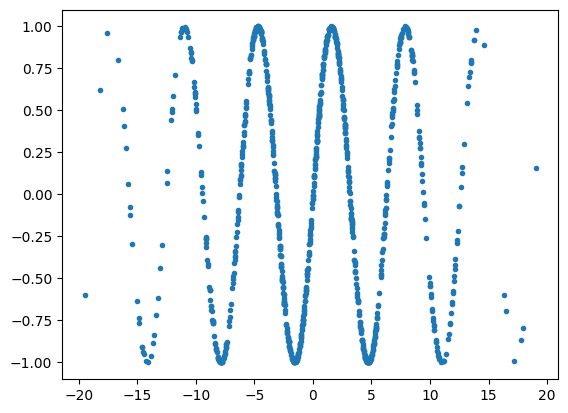

In [4]:
plt.plot(data_train[:, 0], data_train[:, 1], ".")

In [19]:
# pytorch data loader
batch_size = 32
data_train_loader = torch.utils.data.DataLoader(data_train_set, batch_size=batch_size, shuffle=True)

In [11]:
# the dicriminator network,receives two dimensional input either from real data or the generated 
# sample, with a one dimensional output, representing which distribution the input belonged to.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [16]:
# the generator network, receives a 2d point from the latent space, 
# and outputs a 2d point, which should resemble the real data ditribution 
# from training dataset.
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.model(x)

In [30]:
dis = Discriminator()
gen = Generator()
dis_loss_func = nn.BCELoss()
gen_loss_func = nn.BCELoss()

In [31]:
lr = 0.001
num_epochs = 500

In [32]:
dis_optim = torch.optim.Adam(dis.parameters(), lr=lr)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr)

In [36]:
for e in range(num_epochs):
    for b, (real_samples, _) in enumerate(data_train_loader):
        # prepare data for training the discriminator
        real_samples_labels  = torch.ones((batch_size, 1))  # labels for real samples from training data: 1
        latent_samples       = torch.randn((batch_size, 2)) # randomly drawn samples
        gen_samples          = gen(latent_samples)          # generated samples from the generator network
        gen_samples_labels   = torch.zeros((batch_size, 1)) # generated samples labels: 0
        real_and_gen_samples = torch.cat((real_samples, gen_samples))
        real_and_gen_labels  = torch.cat((real_samples_labels, gen_samples_labels))
        
        # training discriminator
        dis.zero_grad()
        dis_output = dis(real_and_gen_samples)
        dis_loss = dis_loss_func(dis_output, real_and_gen_labels)
        dis_loss.backward()
        dis_optim.step()
        
        # new random data from latent space for training the generator
        latent_samples = torch.randn((batch_size, 2))
        
        # training the generator
        gen.zero_grad()
        gen_output = gen(latent_samples)
        dis_output_from_gen = dis(gen_output) # output of discriminator from generated samples
        gen_loss = gen_loss_func(dis_output_from_gen, real_samples_labels)
        gen_loss.backward()
        gen_optim.step()
        
        # print loss every 10 epoch for the final example in a batch
        if (e % 10 == 0) and (b == batch_size - 1):
            print(f"Epoch: {e}: Generator Loss: {gen_loss}, Discriminator Loss: {dis_loss}")

Epoch: 0: Generator Loss: 1.3132091760635376, Discriminator Loss: 0.3692780137062073
Epoch: 10: Generator Loss: 1.2473597526550293, Discriminator Loss: 0.3557484447956085
Epoch: 20: Generator Loss: 1.220632791519165, Discriminator Loss: 0.47811976075172424
Epoch: 30: Generator Loss: 1.6177812814712524, Discriminator Loss: 0.46523192524909973


KeyboardInterrupt: 

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = gen(latent_space_samples)

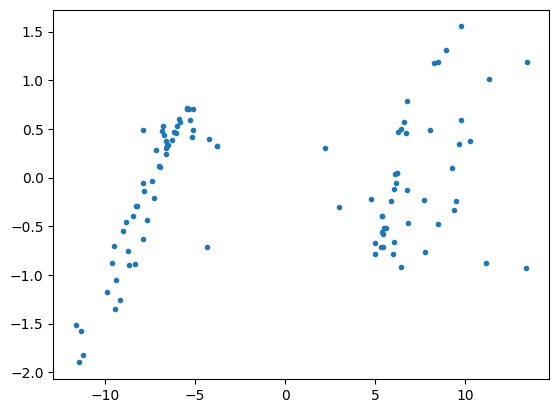

In [35]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [38]:
import torchvision
import torchvision.transforms as transforms

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
# ToTensor transoform ranges from 0 to 1, 0 for black, most of the image background in MNIST 
# is black, so the majority is 0, the Normalize transforms the pixel values to be in range -1 to 1
# by subtracting 0.5 from values and dividing by 0.5. The greyscale image has only one channel and hence,
# 1d tuples
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])